In [1]:
### Uncomment to run in Colab
# !pip install git+https://github.com/pnnl/DeepDataProfiler.git


<img src="images/vgg_profiling.png" alt="VGG Profiling Image" style="width: 400px;float: right;margin: 10pt"/>

# Deep Data Profiler(DDP)

DDP characterizes both the data and the model, pointing to the most influential neurons and weights used for classification and identifying the inter-relationships between neurons in the profiled layers. DDP is currently implemented for Pytorch modules: 
- torch.nn.Linear,
- torch.nn.MaxPool2d,
- torch.nn.AdaptiveAvgPool2d,
- torch.nn.Conv2d

Using these modules, DDP can construct profiles for sequential (VGG-like) and Resnet architectures.

### Important Terms
- Layers - collections of modules across the model. We group weighted modules with their activations and treat these as a single layer. Pooling modules are given their own layers as they affect the indices of contributing neurons.
- Neuron - the index of an input or output tensor for each layer, we identify the most influential neurons
    - A neuron can refer to either a single element or a channel of a tensor, depending on the profile.
- Synapse - a tuple of input and output neurons (and weight indices where appropriate) within a layer
- Profile instance - the critical set of neurons and synapses (up to a threshold value) that leads to a final predicted class
- Threshold - a parameter to determine the neurons and synapses used for the profile
- Class Profile - an aggregation of profile instances for inputs from the same class
- Jaccard metrics 
    - Computes similarity between profiles
    - Can cluster sets of profiles

### Import libraries and data

In [2]:
import cv2
import deep_data_profiler as ddp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import torch
import torchvision.models.resnet as resnet
import torchvision.models.vgg as vgg
from torchvision.transforms import Compose, Normalize
from torchvision.transforms.functional import to_tensor

In [3]:
## To ensure reproducibility we set the pytorch seed. This only works if the versioning of libraries is held
## constant
torch.manual_seed(0)
## We will also specify the device. The profiling code will run on cpu or cuda.
device=torch.device('cpu')

---
# What is a neuron?

CNN's produce 3-dimensional *tensors* of activations, and we can slice the tensor into many neuron units in a few different ways. 
There are two different ways we can use neurons to track influence across the activations of a CNN. A "neuron" can refer to either a single channel of a convolutional layer, or to a single element. The choice of element or channel definition of neurons is consistent throughout a single profile.

A $c\times m\times n$ activation tensor is a stack of $c$ channels;each channel is an $m\times n$ matrix. The activation tensor can be divided into:
- **$c$ channel activations**: a neuron is an $m\times n$ channel
- **$mn$ spatial activations**: a neuron is a $c$-vector tube through all channels in a fixed spatial position
- **$cmn$ element activations**: a neuron is a single element of the tensor at a fixed channel and fixed spatial position

\#TODO: update picture to include spatials

<center><img src="images/synapsetypes.png" alt="Synapse Types" style="width: 800px;margin: 10pt"/></center>

<b>Note</b>: The multiple definitions of *neuron* only apply to convolutional layers; the elements of a fully-connected linear layer are always treated as individual neurons.

There is one profiler class for each neuron type: **`ddp.ChannelProfiler`**, **`ddp.ElementProfiler`**, and **`ddp.SpatialProfiler`**. We'll demonstrate the use of all three.

---
<img src="images/eagleimage.png" alt="VGG Profiling Image" style="width: 175px;float: right;margin: 15pt"/>

# How do we compute a profile?


Profiling requires a pretrained model and data that mirrors the training data. In this example the model is a TorchVision pretrained VGG16 model. 

We create a profiler for the data by instantiating one of the three Profiler classes with the 
pretrained model. Here we are using `ddp.ElementProfiler`, but steps 1 - 3 are the same for any Profiler class.

We preprocess the eagle image on the right into Pytorch tensors suitable as input for the VGG16 model. To create a 
profile for these images we then use the Profiler's <code>create_profile()</code> method on the image.

## 1. Generate the data
We preprocess an eagle image from Imagenet by applying the transformations that were used on the training set (i.e. normalizing, resizing, etc.):

In [4]:
### Uncomment the following to run in Colab
# !wget -qnc "https://raw.githubusercontent.com/pnnl/DeepDataProfiler/master/tutorials/images/n01614925/ILSVRC2012_val_00046632.JPEG"
# img = cv2.imread('ILSVRC2012_val_00046632.JPEG')

### Uncomment the following to run locally
imagepath = 'images/n01614925/ILSVRC2012_val_00046632.JPEG'
img = cv2.imread(imagepath)

In [5]:
def torch_image(img):
    """normalize the values and resize for processing"""
    norm=((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    normalize = Compose([Normalize(mean=norm[0], std=norm[1])])
    img = np.expand_dims(img, 2).repeat(3, axis=2) if len(img.shape) == 2 else img
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = to_tensor(img)
    return torch.unsqueeze(normalize(img),0)

timage = torch_image(img)

## 2. Choose a model

We create an instance of the **`ddp.ElementProfiler`** class, which allows us to use all the attributes and methods of the Profiler for the model. We will highlight some of these methods and attributes, including:

- `available_modules()` : returns a list of available module names and associated models
- `layerdict` : a dictionary of layers used for profiling
- `create_profile()` : generates a profile for a single input as it passes through the layers

Here we instantiate the PyTorch VGG-16 model and its DDP ElementProfiler, `elem_profiler`.

Uncomment the Resnet code to see the tutorial with ResNet.

In [6]:
model = vgg.vgg16(pretrained=True).to(device).eval()
# model = resnet.resnet18(pretrained=True).eval()
element_profiler = ddp.ElementProfiler(model)

## 3. Decide which layers to profile. 
A profile represents connections between the layers of the network, and we may not always want to profile all of the layers. First let's take a look at the available modules in each layer.

In [7]:
element_profiler.model.available_modules()

OrderedDict([('features.0',
              Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.1', ReLU(inplace=True)),
             ('features.2',
              Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.3', ReLU(inplace=True)),
             ('features.4',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('features.5',
              Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.6', ReLU(inplace=True)),
             ('features.7',
              Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
             ('features.8', ReLU(inplace=True)),
             ('features.9',
              MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)),
             ('features.10',
              Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))),
           

For profiling, layers are weighted modules or pooling modules. We construct a layer dictionary to pass to the profiler.

In [8]:
## note the helper function referenced in each layer start with _contrib and 
## refer to the type of Pytorch layer being profiled
element_profiler.layerdict

OrderedDict([(0, [['x_in'], 'contrib_identity']),
             (1, [['features.0', 'features.1'], 'contrib_conv2d']),
             (2, [['features.2', 'features.3'], 'contrib_conv2d']),
             (3, [['features.4'], 'contrib_max2d']),
             (4, [['features.5', 'features.6'], 'contrib_conv2d']),
             (5, [['features.7', 'features.8'], 'contrib_conv2d']),
             (6, [['features.9'], 'contrib_max2d']),
             (7, [['features.10', 'features.11'], 'contrib_conv2d']),
             (8, [['features.12', 'features.13'], 'contrib_conv2d']),
             (9, [['features.14', 'features.15'], 'contrib_conv2d']),
             (10, [['features.16'], 'contrib_max2d']),
             (11, [['features.17', 'features.18'], 'contrib_conv2d']),
             (12, [['features.19', 'features.20'], 'contrib_conv2d']),
             (13, [['features.21', 'features.22'], 'contrib_conv2d']),
             (14, [['features.23'], 'contrib_max2d']),
             (15, [['features.24', 'fea

In this example, we will profile <b>all layers</b> of the model. To profile a subset of the layers, pass either a list of layers $[L_1, L_2, \dots, L_n]$ or a tuple-formatted range $(L_1, L_n) = [L_1, L_2, \dots, L_{n-1}]$ to <code>create_profile()</code> as the <code>layers_to_profile</code> argument.

## 4. Instantiate the Profile
**The primary purpose of a Profiler object is to generate `ddp.Profile` objects for input data as it passes through the layers of a model.**

We can create profiles of the image using all three Profilers, thresholding at 10%. We'll discuss the differences between the profiles in the next section.

<b>Note:</b> You can experiment with different thresholds, though high thresholds will take longer to compute

In [9]:
channel_profiler = ddp.ChannelProfiler(model)
spatial_profiler = ddp.SpatialProfiler(model)

In [10]:
%%time
element_profile = element_profiler.create_profile(timage,threshold=0.1)  

CPU times: user 1.39 s, sys: 173 ms, total: 1.56 s
Wall time: 1.35 s


In [11]:
%%time
channel_profile = channel_profiler.create_profile(timage,threshold=0.1)  

CPU times: user 1.87 s, sys: 410 ms, total: 2.28 s
Wall time: 1.57 s


**Note**: `ddp.SpatialProfiler.create_profile()` takes slightly different arguments from the other two Profilers. Influential spatial neurons are identified by strength (vector norm), while contributors are identified by the strength of their contribution *in the direction of the influential vector*. Since these two measures of strength are different, their thresholds are set separately as the `infl_threshold` and `contrib_threshold` arguments. Here we're using the default parameters for identifying influence, and a 10% contribution threshold.

In [12]:
%%time
spatial_profile = spatial_profiler.create_profile(timage,contrib_threshold=0.1)

CPU times: user 1.16 s, sys: 96 ms, total: 1.26 s
Wall time: 1.03 s


## 5. Plot the Profile Graph
Tutorial 3 gives a detailed walkthrough of this process.

In [13]:
profile_dict = channel_profile.dict_view()
T = ddp.tuples_from_dict(profile_dict.synapse_weights)
G = ddp.graph_from_tuples(T)

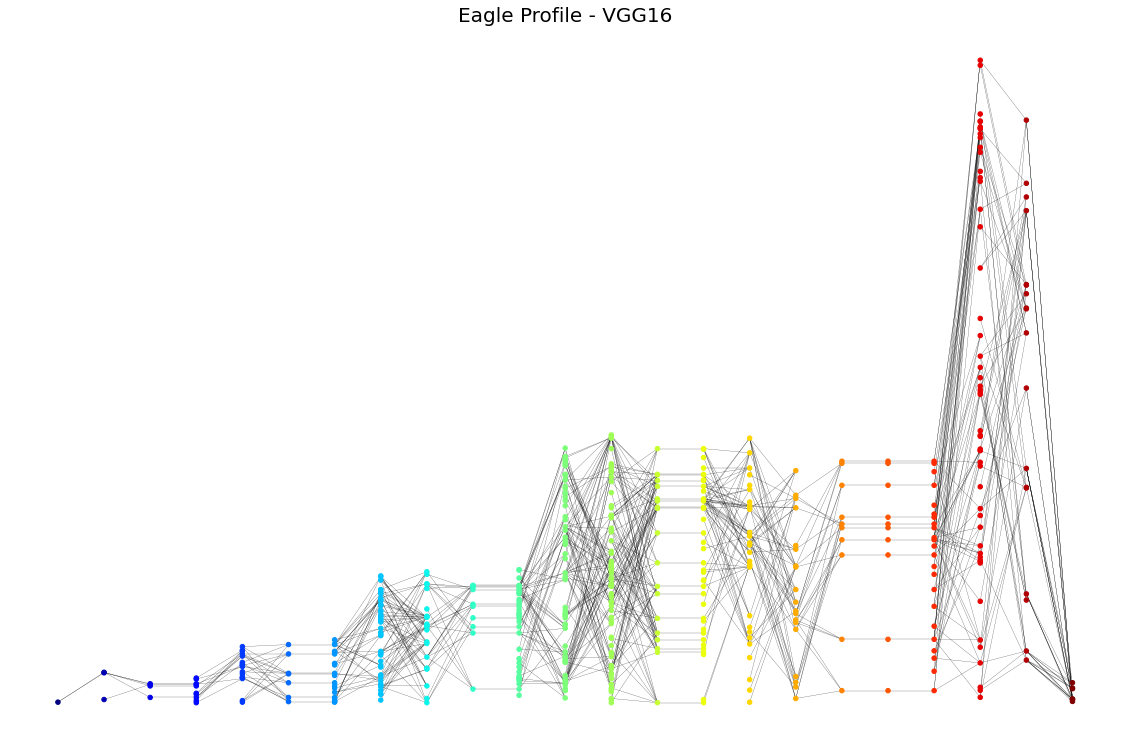

In [14]:
fig, ax = plt.subplots(figsize=(20,13))
ax.axis('off')
# position nodes by layer and index (with VGG16 FC layer positions scaled by 0.3)
position = {node:(node[0],node[1][0]) if node[0] < 20 else (node[0],0.3*node[1][0])
            for node in G.nodes}
## Uncomment to plot without scaling
# position = {node:(node[0],node[1][0]) for node in G.nodes}
ax.set_title('Eagle Profile - VGG16', fontsize=20)
nx.draw(G,ax=ax,node_size=20,width=0.2, node_color=[v[0] for v in G.nodes], cmap='jet', pos=position, arrows=False)

---
# What is in a Profile Object?

Let's look at a profile of a single image in the eagles class. We use the profile to find the largest contributors among the neurons and weights that lead to the final classification. Each profile contains python dictionaries of neuron_counts, synapse_counts, and synapse_weights, listing the significant contributors for the layers profiled.
Each profile has aggregation metrics of total and size. Profiles may be added together to form a new profile or added in place.

- `neuron_counts` : dictionary of sparse matrices, representing the number of significant synapses each neuron participates in at each layer.
- `neuron_weights` : dictionary of sparse matrices, representing the weight of influential neurons at each layer
- `synapse counts` : dictionary of sparse matrices, representing to the counts of connections between input and output neurons through each layer
- `synapse weights` :  dictionary of sparse matrices, representing the weighted connections between input and output neurons through each layer
- `activation_shapes` : dictionary of tensor shapes, representing the shape of the activations for each layer
- `pred_dict` : dictionary of lists, linking each layer index to a list of predecessors, or indices of input layers that feed into it
- `num_inputs` : int, the number of input images a profile is constructed from (i.e. if you add two single image profiles with num_inputs = 1, the resulting aggregate profile will have num_inputs = 2
- `neuron_type` : string (optional), 'element', 'spatial', or 'channel' according to the Profiler that created it


One useful method for examining an existing profile is <code>ddp.Profile.dict_view()</code>, which returns a new Profile object where dictionaries are used to represent the counts and weights data originally held by sparse matrices.

In [15]:
# dict_view returns a dummy Profile object that holds dictionary representations of each count and weight
channel_profile_dict = channel_profile.dict_view()
element_profile_dict = element_profile.dict_view()
spatial_profile_dict = spatial_profile.dict_view()

The dictionaries give a more detailed view of which neurons are important, since it uses correct full indices for each neuron while the sparse matrix format flattens indices to store information. It also includes important layer information for synapses, which is not given by the sparse matrix.

## Neuron Counts: 
The neuron counts represent the contributing neurons and the number of times each contributes within the layer. In this example we used a threshold of 0.1, meaning for each influential neuron $m$, we searched for the smallest set of neurons $\{n_\alpha\}$ in the previous layer which would contribute $10\%$ of the value of the neuron at $m$.

In a **channel** profile (dictionary view), the entry for $(L, (c,))$ gives the number of times channel $c$ has been identified as either influential within its layer $L$, or as a contributor to an influential neuron in the following layer.

In [16]:
## Neuron counts of an early convolutional layer (4) with 128 channels
channel_profile_dict.neuron_counts[4]

{(4, (1,)): 2,
 (4, (4,)): 2,
 (4, (46,)): 2,
 (4, (48,)): 1,
 (4, (49,)): 2,
 (4, (55,)): 1,
 (4, (59,)): 2,
 (4, (69,)): 2,
 (4, (71,)): 1,
 (4, (72,)): 1,
 (4, (75,)): 1,
 (4, (77,)): 2,
 (4, (89,)): 2,
 (4, (93,)): 5,
 (4, (99,)): 1,
 (4, (100,)): 1,
 (4, (107,)): 3}

In an **element** profile (dictionary view), the entry for $(L, (c,i,j))$ gives the number of times the element located at $(i,j)$ in channel $c$ has been identified as either influential within its layer $L$, or as a contributor to an influential neuron in the following layer.

In [17]:
element_profile_dict.neuron_counts[4]

{(4, (100, 25, 55)): 1,
 (4, (99, 32, 86)): 1,
 (4, (72, 36, 33)): 1,
 (4, (72, 37, 32)): 1,
 (4, (46, 39, 72)): 2,
 (4, (72, 40, 73)): 1,
 (4, (123, 41, 72)): 1,
 (4, (124, 41, 100)): 1,
 (4, (78, 42, 100)): 1,
 (4, (127, 42, 102)): 1,
 (4, (17, 43, 101)): 1,
 (4, (71, 62, 22)): 1,
 (4, (48, 63, 22)): 1,
 (4, (93, 80, 65)): 2,
 (4, (69, 80, 66)): 1,
 (4, (75, 82, 62)): 1,
 (4, (89, 87, 59)): 1}

In a **spatial** profile (dictionary view), the entry for $(L,(i,j))$ gives the number of times the spatial located at $(i,j)$ has been identified as either influential within its layer $L$, or as a contributor to an influential neuron in the following layer.

In [18]:
spatial_profile_dict.neuron_counts[4]

{(4, (25, 54)): 1,
 (4, (25, 55)): 1,
 (4, (25, 56)): 1,
 (4, (26, 50)): 1,
 (4, (26, 60)): 1,
 (4, (26, 61)): 1,
 (4, (26, 66)): 1,
 (4, (27, 54)): 1,
 (4, (27, 55)): 1,
 (4, (27, 56)): 1,
 (4, (27, 60)): 1,
 (4, (27, 61)): 1,
 (4, (27, 62)): 1,
 (4, (28, 74)): 1,
 (4, (30, 80)): 1,
 (4, (30, 81)): 1,
 (4, (30, 82)): 1,
 (4, (32, 86)): 1,
 (4, (32, 87)): 1,
 (4, (33, 87)): 1,
 (4, (34, 90)): 1,
 (4, (35, 90)): 1,
 (4, (36, 73)): 1,
 (4, (36, 94)): 1,
 (4, (37, 89)): 1,
 (4, (37, 90)): 1,
 (4, (37, 94)): 1,
 (4, (37, 95)): 1,
 (4, (37, 96)): 1,
 (4, (38, 97)): 1,
 (4, (38, 98)): 1,
 (4, (39, 71)): 1,
 (4, (39, 72)): 3,
 (4, (39, 95)): 1,
 (4, (39, 96)): 2,
 (4, (39, 97)): 1,
 (4, (39, 98)): 1,
 (4, (39, 99)): 1,
 (4, (40, 71)): 1,
 (4, (40, 73)): 1,
 (4, (40, 96)): 1,
 (4, (40, 97)): 2,
 (4, (40, 98)): 2,
 (4, (40, 99)): 1,
 (4, (40, 100)): 2,
 (4, (41, 72)): 2,
 (4, (41, 90)): 1,
 (4, (41, 98)): 1,
 (4, (41, 99)): 2,
 (4, (41, 100)): 2,
 (4, (41, 101)): 2,
 (4, (42, 99)): 1,
 (4, (42,

## Neuron Weights
Unlike neuron counts, which are incremented equally whether a neuron is a contributor to an influential neuron or is influential itself, neuron weights are assigned only to the neurons that are identified as influential in their layer. Neuron weights have the same format as neuron counts, but the values represent their relative importance among all neurons in that layer. 

For the **channel and element** profiles the threshold of 0.1 means that we considered the maximum activation from each channel as our set of neurons and chose the top $10\%$ as influential. This method is similar to the method of identifying contributors; we can think of the neurons in terms of their contribution to a percentage of the total sum of maximum activations from each channel.

In a **channel** profile (dictionary view), the entry for $(L, (c,))$ gives the weight of channel $c$ of layer $L$.

In [19]:
channel_profile_dict.neuron_weights[4]

{(4, (46,)): 0.13248938,
 (4, (69,)): 0.1422278,
 (4, (75,)): 0.13994025,
 (4, (89,)): 0.15271237,
 (4, (93,)): 0.14463864,
 (4, (99,)): 0.14085399,
 (4, (100,)): 0.14713757}

In [20]:
# weights sum to 1
print(f'Sum of weights: {sum(channel_profile_dict.neuron_weights[4].values())}')

Sum of weights: 1.0


In an **element** profile (dictionary view), the entry for $(L,(c,i,j))$ gives the weight of the element located at position $(i,j)$ in channel $c$ of layer $L$. If the weight is greater than zero, then $(i,j)$ is the position of the maximum value in channel $c$.

In [21]:
element_profile_dict.neuron_weights[4]

{(4, (100, 25, 55)): 0.14713757,
 (4, (99, 32, 86)): 0.14085399,
 (4, (46, 39, 72)): 0.13248938,
 (4, (93, 80, 65)): 0.14463864,
 (4, (69, 80, 66)): 0.1422278,
 (4, (75, 82, 62)): 0.13994025,
 (4, (89, 87, 59)): 0.15271237}

Note that for each influential channel in the channel-wise profile there is a corresponding influential element within the same channel with the same weight in the element-wise profile. This is because the method of identifying influential neurons from strong activations is the same between element-wise and channel-wise profiles, but the influential neuron is represented with higher granularity in the element-wise profile.

For the **spatial** profile, the default measure of influence is to take the top 97th percentile of spatials by their vector norm as influential neurons, up to a maximum of 100 influential neurons per layer. In the spatial profile (dictionary view), the entry for $(L,(i,j))$ gives the weight of the spatial located at $(i,j)$ in layer $L$.

In [22]:
spatial_profile_dict.neuron_weights[4]

{(4, (25, 54)): 0.009743999,
 (4, (25, 55)): 0.00987372,
 (4, (25, 56)): 0.00973432,
 (4, (26, 50)): 0.009583385,
 (4, (26, 60)): 0.010678386,
 (4, (26, 61)): 0.01057357,
 (4, (26, 66)): 0.009202977,
 (4, (27, 54)): 0.009404896,
 (4, (27, 55)): 0.009706877,
 (4, (27, 56)): 0.009651684,
 (4, (27, 60)): 0.009811121,
 (4, (27, 61)): 0.010197389,
 (4, (27, 62)): 0.009526643,
 (4, (28, 74)): 0.009380468,
 (4, (30, 80)): 0.009941247,
 (4, (30, 81)): 0.009822426,
 (4, (30, 82)): 0.010138359,
 (4, (32, 86)): 0.009278261,
 (4, (33, 87)): 0.009186506,
 (4, (34, 90)): 0.009876198,
 (4, (35, 90)): 0.010028781,
 (4, (37, 95)): 0.009679814,
 (4, (38, 97)): 0.009459774,
 (4, (39, 72)): 0.009790947,
 (4, (39, 96)): 0.009620762,
 (4, (39, 98)): 0.009393885,
 (4, (40, 97)): 0.009294335,
 (4, (40, 98)): 0.009444482,
 (4, (40, 99)): 0.0097606275,
 (4, (40, 100)): 0.009280011,
 (4, (41, 72)): 0.009801208,
 (4, (41, 99)): 0.009386062,
 (4, (41, 100)): 0.009770159,
 (4, (41, 101)): 0.009417483,
 (4, (42, 100

## Synapse Counts
The synapse counts are represented internally by a sparse matrix that acts as an adjacency matrix between two layers. As with the neuron counts and weights, the dictionary view gives a more detailed and user friendly reading. For a profile of a single input all synapse counts will be either zero or one. In a class profile a count $n$, $n > 1$ means that a synapse has been present in $n$ of the image profiles aggregated to form the class profile.

In a **channel** profile (dictionary view), the entry for $((L_x,(c_x,)),(L_y,(c_y,))$ represents the synapse between contributing channel $c_x$ in input layer $L_x$ and influential channel $c_y$ in output layer $L_y$.

Note: In VGG/sequential architectures, $L_x = L_y - 1$, but we avoid this generalization as it is not always the case in ResNet architectures.

In [23]:
channel_profile_dict.synapse_counts[4]

{((3, (0,)), (4, (46,))): 1,
 ((3, (4,)), (4, (99,))): 1,
 ((3, (10,)), (4, (75,))): 1,
 ((3, (10,)), (4, (89,))): 1,
 ((3, (10,)), (4, (93,))): 1,
 ((3, (16,)), (4, (89,))): 1,
 ((3, (18,)), (4, (99,))): 1,
 ((3, (32,)), (4, (93,))): 1,
 ((3, (35,)), (4, (46,))): 1,
 ((3, (36,)), (4, (69,))): 1,
 ((3, (45,)), (4, (69,))): 1,
 ((3, (47,)), (4, (100,))): 1}

In an **element** profile (dictionary view), the entry for $((L_x,(c_x,i_x,j_x)),(L_y,(c_y,i_y,j_y))$ represents the synapse between contributing element $(i_x,j,_x)$ in channel $c_x$ of input layer $L_x$ and influential element $(i_y,j_y)$ in channel $c_y$ of output layer $L_y$.

In [24]:
element_profile_dict.synapse_counts[4]

{((3, (4, 33, 86)), (4, (99, 32, 86))): 1,
 ((3, (5, 39, 71)), (4, (46, 39, 72))): 1,
 ((3, (10, 80, 65)), (4, (93, 80, 65))): 1,
 ((3, (10, 82, 62)), (4, (75, 82, 62))): 1,
 ((3, (10, 86, 59)), (4, (89, 87, 59))): 1,
 ((3, (11, 80, 65)), (4, (69, 80, 66))): 1,
 ((3, (35, 39, 71)), (4, (46, 39, 72))): 1,
 ((3, (45, 26, 55)), (4, (100, 25, 55))): 1,
 ((3, (63, 87, 58)), (4, (89, 87, 59))): 1}

In a **spatial** profile (dictionary view), the entry for $((L_x,(i_x,j_x)),(L_y,(i_y,j_y))$ represents the synapse between contributing spatial $(i_x,j,_x)$ in input layer $L_x$ and influential spatial $(i_y,j_y)$ in output layer $L_y$.

In [25]:
spatial_profile_dict.synapse_counts[4]

{((3, (26, 54)), (4, (25, 54))): 1,
 ((3, (26, 54)), (4, (27, 54))): 1,
 ((3, (26, 55)), (4, (25, 55))): 1,
 ((3, (26, 55)), (4, (27, 55))): 1,
 ((3, (26, 56)), (4, (25, 56))): 1,
 ((3, (26, 56)), (4, (27, 56))): 1,
 ((3, (27, 50)), (4, (26, 50))): 1,
 ((3, (27, 60)), (4, (26, 60))): 1,
 ((3, (27, 60)), (4, (27, 60))): 1,
 ((3, (27, 61)), (4, (26, 61))): 1,
 ((3, (27, 61)), (4, (27, 61))): 1,
 ((3, (27, 62)), (4, (27, 62))): 1,
 ((3, (27, 66)), (4, (26, 66))): 1,
 ((3, (29, 74)), (4, (28, 74))): 1,
 ((3, (31, 80)), (4, (30, 80))): 1,
 ((3, (31, 81)), (4, (30, 81))): 1,
 ((3, (31, 82)), (4, (30, 82))): 1,
 ((3, (32, 86)), (4, (32, 86))): 1,
 ((3, (33, 87)), (4, (33, 87))): 1,
 ((3, (35, 89)), (4, (34, 90))): 1,
 ((3, (35, 90)), (4, (35, 90))): 1,
 ((3, (38, 95)), (4, (37, 95))): 1,
 ((3, (39, 72)), (4, (39, 72))): 1,
 ((3, (39, 96)), (4, (39, 96))): 1,
 ((3, (39, 97)), (4, (38, 97))): 1,
 ((3, (39, 98)), (4, (39, 98))): 1,
 ((3, (40, 97)), (4, (40, 97))): 1,
 ((3, (40, 98)), (4, (40, 98

## Synapse Weights
Synapse weights are sparse matrices with the same shape as the corresponding synapse counts for the layer. While synapse counts describe which synapses exist between two layers, synapse weights describe the weights assigned to those synapses. With a threshold of 0.1, the weight of a synapse is the proportion of $10\%$ of the influential neuron's value that is provided by the value of the contributing neuron.

In [26]:
channel_profile_dict.synapse_weights[4]

{((3, (0,)), (4, (46,))): 0.42645276,
 ((3, (4,)), (4, (99,))): 0.6417866,
 ((3, (10,)), (4, (75,))): 1.0,
 ((3, (10,)), (4, (89,))): 0.5492262,
 ((3, (10,)), (4, (93,))): 0.45697334,
 ((3, (16,)), (4, (89,))): 0.45077378,
 ((3, (18,)), (4, (99,))): 0.35821348,
 ((3, (32,)), (4, (93,))): 0.5430267,
 ((3, (35,)), (4, (46,))): 0.5735473,
 ((3, (36,)), (4, (69,))): 0.41881675,
 ((3, (45,)), (4, (69,))): 0.5811832,
 ((3, (47,)), (4, (100,))): 1.0}

In [27]:
element_profile_dict.synapse_weights[4]

{((3, (4, 33, 86)), (4, (99, 32, 86))): 1.0,
 ((3, (5, 39, 71)), (4, (46, 39, 72))): 0.52163416,
 ((3, (10, 80, 65)), (4, (93, 80, 65))): 1.0,
 ((3, (10, 82, 62)), (4, (75, 82, 62))): 1.0,
 ((3, (10, 86, 59)), (4, (89, 87, 59))): 0.485981,
 ((3, (11, 80, 65)), (4, (69, 80, 66))): 1.0,
 ((3, (35, 39, 71)), (4, (46, 39, 72))): 0.47836587,
 ((3, (45, 26, 55)), (4, (100, 25, 55))): 1.0,
 ((3, (63, 87, 58)), (4, (89, 87, 59))): 0.514019}

In [28]:
spatial_profile_dict.synapse_weights[4]

{((3, (26, 54)), (4, (25, 54))): 0.4870684,
 ((3, (26, 54)), (4, (27, 54))): 0.2830297,
 ((3, (26, 55)), (4, (25, 55))): 0.4747562,
 ((3, (26, 55)), (4, (27, 55))): 0.28241995,
 ((3, (26, 56)), (4, (25, 56))): 0.47766137,
 ((3, (26, 56)), (4, (27, 56))): 0.2901883,
 ((3, (27, 50)), (4, (26, 50))): 0.41660118,
 ((3, (27, 60)), (4, (26, 60))): 0.35366324,
 ((3, (27, 60)), (4, (27, 60))): 0.39913508,
 ((3, (27, 61)), (4, (26, 61))): 0.3612217,
 ((3, (27, 61)), (4, (27, 61))): 0.41164973,
 ((3, (27, 62)), (4, (27, 62))): 0.39610118,
 ((3, (27, 66)), (4, (26, 66))): 0.49287507,
 ((3, (29, 74)), (4, (28, 74))): 0.37123936,
 ((3, (31, 80)), (4, (30, 80))): 0.35341603,
 ((3, (31, 81)), (4, (30, 81))): 0.38279265,
 ((3, (31, 82)), (4, (30, 82))): 0.45260894,
 ((3, (32, 86)), (4, (32, 86))): 0.29359636,
 ((3, (33, 87)), (4, (33, 87))): 0.41671997,
 ((3, (35, 89)), (4, (34, 90))): 0.34541598,
 ((3, (35, 90)), (4, (35, 90))): 0.35523316,
 ((3, (38, 95)), (4, (37, 95))): 0.33679673,
 ((3, (39, 72))